<a href="https://colab.research.google.com/github/codeSamuraii/ml-experiments/blob/main/ImageEnhancementCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image enhancement using an encoder-decoder CNN
The goal of this notebook is to use an encoder-decoder CNN model to deblock and enhance JPEG-compressed images.

## Preparation


### Kaggle

In [ ]:
import os
import getpass

kaggle_ids = getpass.getpass('Content of your ~/.kaggle/kaggle.json: ')
os.environ['KAGGLE_JSON'] = kaggle_ids

!mkdir ~/.kaggle; echo $KAGGLE_JSON > ~/.kaggle/kaggle.json; chmod 600 ~/.kaggle/kaggle.json

Content of your ~/.kaggle/kaggle.json: ··········


### Downloading and compressing images



In [ ]:
!mkdir /content/dataset; kaggle datasets download -d farhanhaikhan/general-purpose-image-dataset -p /content/dataset --unzip; mv /content/dataset/dataset/* /content/dataset/

100% 1.45G/1.45G [00:37<00:00, 43.2MB/s]
100% 1.45G/1.45G [00:37<00:00, 41.4MB/s]


In [ ]:
import os
import pathlib
import tempfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from random import choice
from itertools import chain
from tensorflow import keras
from keras import layers
from keras.models import Sequential


img_width, img_height = 448, 448


def process_images_for_training(src_directory, dest_directory, quality_factor=5):
    folder = pathlib.Path(src_directory).resolve()
    extensions = {'*.jpg', '*/*.jpg', '*.jpeg', '*/*.jpeg'}
    images = set(chain.from_iterable(folder.glob(ext) for ext in extensions))

    nb_img, nb_errors, nb_wrongsize = len(images), 0, 0
    print(f'Found {nb_img} images.')

    for i, image_file in enumerate(images):
        try:
            im = Image.open(image_file)
        except OSError:
            nb_errors += 1
            continue

        if im.width < img_width or im.height < img_height:
            nb_wrongsize += 1
            continue

        try:
            im.save(f'{dest_directory}/quality/{i}.jpg', optimize=True, quality=100)
        except OSError:
            nb_errors += 1
            continue
        else:
            im.save(f'{dest_directory}/compressed/{i}.jpg', optimize=False, quality=quality_factor)

        if i % 250 == 0:
            progress = i / nb_img * 100
            print(f'{progress:.2f}% ({i}/{nb_img} WS={nb_wrongsize} E={nb_errors})')

    print('Done.')
    return nb_img - nb_errors - nb_wrongsize


In [ ]:
!rm -rf training; mkdir /content/training; mkdir /content/training/compressed; mkdir /content/training/quality
process_images_for_training('/content/dataset', '/content/training', quality_factor=7)

Found 5894 images.
0.00% (0/5894 WS=0 E=0)
4.24% (250/5894 WS=53 E=0)
8.48% (500/5894 WS=111 E=1)
16.97% (1000/5894 WS=229 E=2)
29.69% (1750/5894 WS=406 E=5)
33.93% (2000/5894 WS=459 E=6)
42.42% (2500/5894 WS=579 E=6)
46.66% (2750/5894 WS=639 E=7)
55.14% (3250/5894 WS=759 E=8)
59.38% (3500/5894 WS=814 E=9)
63.62% (3750/5894 WS=881 E=10)
67.87% (4000/5894 WS=941 E=10)
76.35% (4500/5894 WS=1057 E=11)
80.59% (4750/5894 WS=1122 E=13)
89.07% (5250/5894 WS=1237 E=17)
93.32% (5500/5894 WS=1288 E=18)
97.56% (5750/5894 WS=1341 E=18)
Done.


4502

## Building our data pipeline
Instead of loading all the dataset in memory, we'll use a generator that yields pairs of images, the compressed one to make the prediction on and the ground truth.

### Creating the dataset

In [ ]:
import pathlib

BATCH_SIZE = 16
NB_FILES = len(set(pathlib.Path('/content/training/quality').glob('*.jpg')))
SPE = int(NB_FILES / BATCH_SIZE)
print(f"Batch size: {BATCH_SIZE}\n{NB_FILES} samples\nSPE: {SPE}")

Batch size: 16
4502 samples
SPE: 281


In [ ]:
!pip install -q -U tensorflow-addons
import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from functools import partial
from keras.utils import load_img, img_to_array, array_to_img


def file_to_array(file_path):
    image = load_img(file_path, target_size=(img_width, img_height), keep_aspect_ratio=True)
    return img_to_array(image)

def normalize(img_array):
    return img_array / 255.0

def random_augmentation(image_1, image_2):
    if tf.random.uniform(()) < 0.5:
        image_1 = tf.image.flip_left_right(image_1)
        image_2 = tf.image.flip_left_right(image_2)

    if tf.random.uniform(()) < 0.5:
        image_1 = tf.image.flip_up_down(image_1)
        image_2 = tf.image.flip_up_down(image_2)

    angle = tf.random.uniform(())
    image_1 = tfa.image.rotate(image_1, angle)
    image_2 = tfa.image.rotate(image_2, angle)

    return image_1, image_2

def augment_and_normalize(x_array, y_array):
    x_img, y_img = random_augmentation(x_array, y_array)
    return normalize(x_img), normalize(y_img)

def images_generator(x_path, y_path, *args):
    x_folder = sorted(pathlib.Path(x_path.decode()).iterdir())
    y_folder = sorted(pathlib.Path(y_path.decode()).iterdir())

    zipped = list(zip(x_folder, y_folder))

    while True:
        random.shuffle(zipped)

        for x_file, y_file in zipped:
            yield file_to_array(x_file), file_to_array(y_file)

def get_dataset(sources):
    return tf.data.Dataset.from_generator(images_generator, args=sources, output_signature=(
        tf.TensorSpec(shape=(img_height, img_width, 3)), tf.TensorSpec(shape=(img_height, img_width, 3)),
    )).map(augment_and_normalize, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(1)

dataset_autoencode = get_dataset([b'/content/training/quality', b'/content/training/quality'])
dataset_training = get_dataset([b'/content/training/compressed', b'/content/training/quality'])

### Display dataset

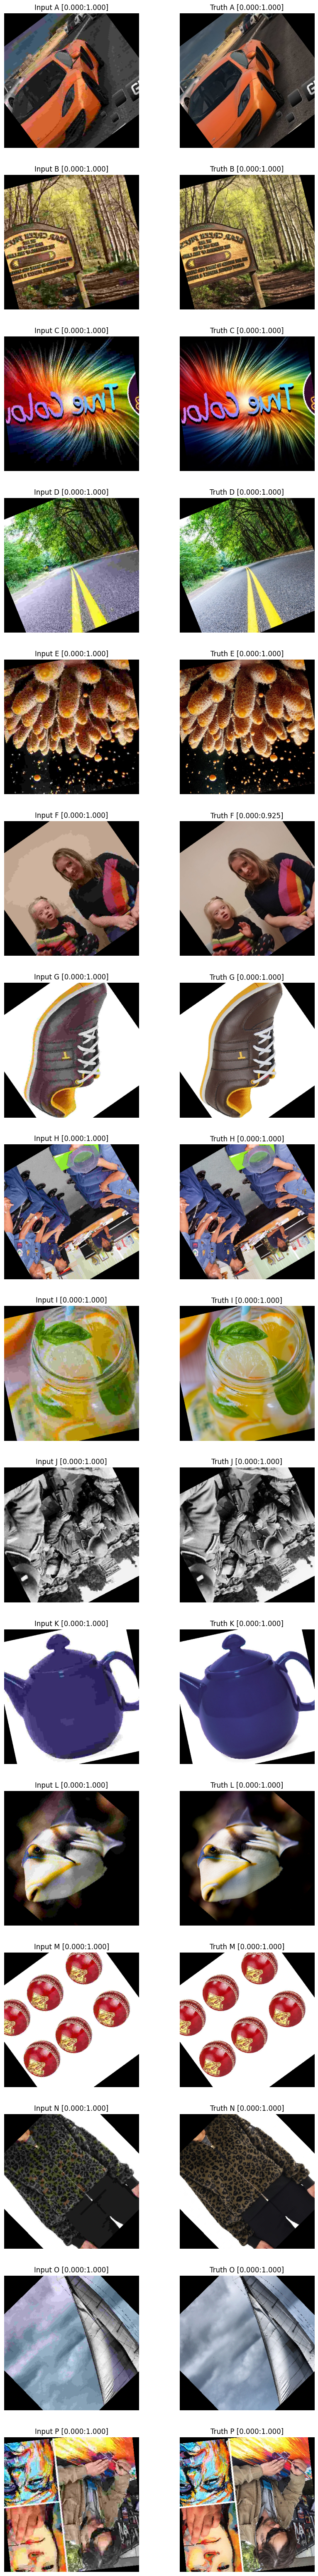

In [ ]:
import string
from matplotlib import pyplot as plt


batch = list(dataset_training.take(1).as_numpy_iterator())
batchX, batchY = batch[0][0], batch[0][1]
choices = zip(range(BATCH_SIZE), string.ascii_uppercase)

plt.figure(figsize=(2 * 5, BATCH_SIZE * 5))

for i, l in choices:
    x = batchX[i]
    pixmin, pixmax = np.min(x), np.max(x)
    img = array_to_img(x * 255.0, scale=False)
    plt.subplot(BATCH_SIZE, 2, i*2 + 1)
    plt.imshow(img)
    plt.title(f'Input {l} [{pixmin:.3f}:{pixmax:.3f}]')
    plt.axis('off')

    y = batchY[i]
    pixmin, pixmax = np.min(y), np.max(y)
    img = array_to_img(y * 255.0, scale=False)
    plt.subplot(BATCH_SIZE, 2, i*2 + 2)
    plt.imshow(img)
    plt.title(f'Truth {l} [{pixmin:.3f}:{pixmax:.3f}]')
    plt.axis('off')

## Building the model
The design of the model is a standard encoder-decoder.

We'll use SSIM as our loss function to try and maximise image similarity between prediction and truth. We'll also monitor PSNR as an additional indicator.

In [ ]:
!rm -f /tmp/*.h5; rm -f /tmp/*.py

import tempfile
import keras.backend as K
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.constraints import max_norm


xargs = dict(padding='same', kernel_initializer='he_uniform')

model = Sequential([
    layers.Conv2D(128, (3, 3), strides=2, input_shape=(img_width, img_height, 3), **xargs),
    layers.LeakyReLU(alpha=0.1),

    layers.Conv2D(128, (3, 3), strides=2, **xargs),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),

    layers.Conv2D(128, (3, 3), strides=2, **xargs),
    layers.LeakyReLU(alpha=0.1),


    layers.Conv2DTranspose(128, (3, 3), strides=2, **xargs),
    layers.LeakyReLU(alpha=0.1),

    layers.Conv2DTranspose(128, (3, 3), strides=2, **xargs),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),

    layers.Conv2DTranspose(128, (3, 3), strides=2, **xargs),
    layers.LeakyReLU(alpha=0.1),

    layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'),
])

def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def custom_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(SSIM(y_true, y_pred))


model.compile(loss=custom_loss,
              metrics=[PSNR, SSIM],
              optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 batch_normalization (Batch  (None, 112, 112, 128)     512       
 Normalization)                                                  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 112, 112, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       147584    
                                                        

## Training

In [ ]:
_, checkpoint_train = tempfile.mkstemp(prefix='training_', suffix='.h5', dir='/tmp')
checkpoint_t = keras.callbacks.ModelCheckpoint(checkpoint_train, monitor='loss', save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(start_from_epoch=5, patience=5, monitor='loss', restore_best_weights=True)

training = model.fit(dataset_training, epochs=50, steps_per_epoch=SPE, callbacks=(checkpoint_t, early_stop))

Epoch 1/50
281/281 [==============================] - 100s 319ms/step - loss: 0.3299 - PSNR: 17.2763 - SSIM: 0.6701
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 [==============================] - 91s 324ms/step - loss: 0.2313 - PSNR: 19.4131 - SSIM: 0.7687
Epoch 3/50
281/281 [==============================] - 90s 321ms/step - loss: 0.2177 - PSNR: 19.8692 - SSIM: 0.7823
Epoch 4/50
281/281 [==============================] - 91s 323ms/step - loss: 0.1993 - PSNR: 21.8729 - SSIM: 0.8007
Epoch 5/50
281/281 [==============================] - 90s 322ms/step - loss: 0.1881 - PSNR: 22.5900 - SSIM: 0.8119
Epoch 6/50
281/281 [==============================] - 91s 325ms/step - loss: 0.1828 - PSNR: 22.7289 - SSIM: 0.8172
Epoch 7/50
281/281 [==============================] - 90s 321ms/step - loss: 0.1807 - PSNR: 22.7816 - SSIM: 0.8193
Epoch 8/50
281/281 [==============================] - 91s 323ms/step - loss: 0.1766 - PSNR: 22.9910 - SSIM: 0.8234
Epoch 9/50
281/281 [==============================] - 91s 322ms/step - loss: 0.1710 - PSNR: 23.7245 - SSIM: 0.8290
Epoch 10/50
281/281 [==============================] - 91s 323ms/step - loss: 0.1675 - PSNR

1/1 [==============================] - 0s 19ms/step


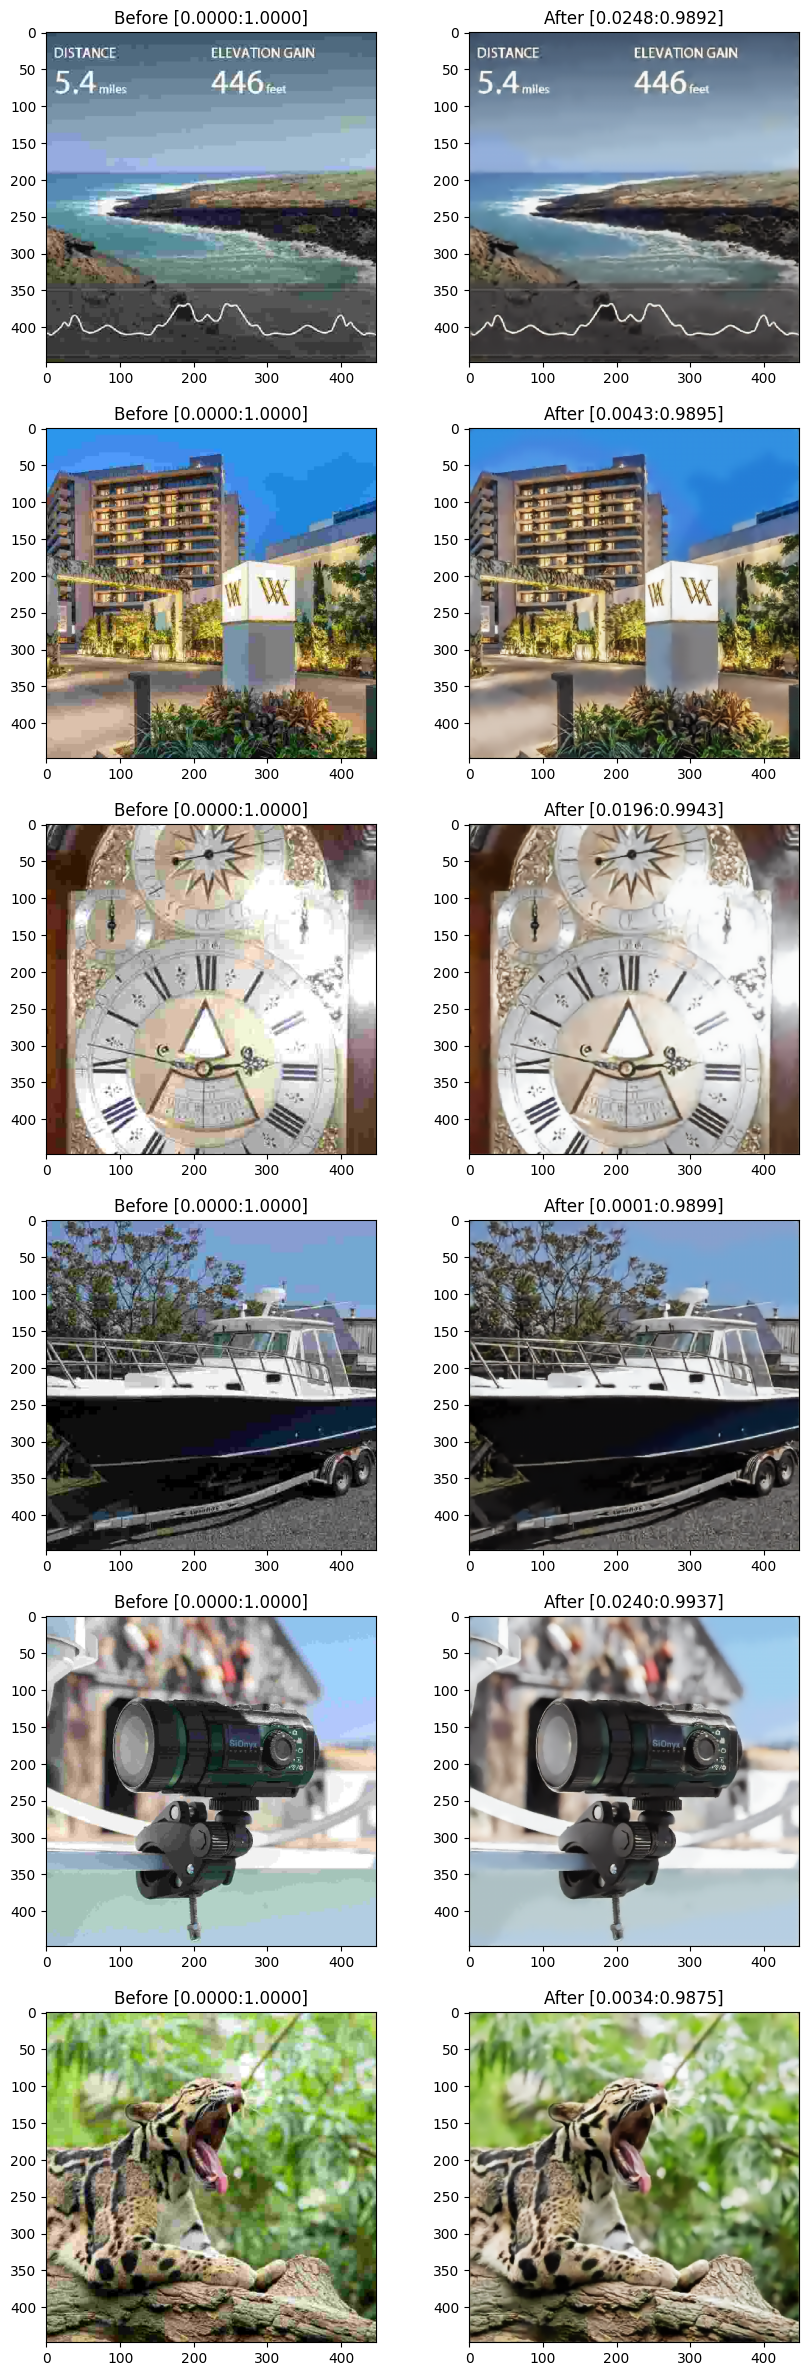

In [ ]:
# @title Results { display-mode: "form" }
import random
import pathlib
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import load_img, img_to_array, array_to_img
from keras.models import Model


if 'checkpoint_train' in locals() and 'training' not in locals():
    print("Loading weights...")
    model.load_weights(checkpoint_train)

originals = random.sample(sorted(pathlib.Path('/content/training/compressed').resolve().iterdir()), 6)
plt.figure(figsize=(10, 30))
i = 0

for original in originals:
    array = normalize(file_to_array(original))

    batch = np.array([array])
    pred = model.predict(batch)

    img_1 = array_to_img(array * 255.0, scale=False)
    img_2 = array_to_img(pred[0] * 255.0, scale=False)

    plt.subplot(6, 2, i + 1)
    plt.imshow(img_1, interpolation=None)
    pixmin, pixmax = np.min(array), np.max(array)
    plt.title(f"Before [{pixmin:.4f}:{pixmax:.4f}]")
    plt.subplot(6, 2, i + 2)
    plt.imshow(img_2, interpolation=None)
    pixmin, pixmax = np.min(pred[0]), np.max(pred[0])
    plt.title(f"After [{pixmin:.4f}:{pixmax:.4f}]")

    i += 2


The results are quite good, all the blocking is gone while retaining most of the image detail.